# Shap Value

In [1]:
# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 버젼보다 최신 버젼을 권장))
# import skimage -> skimage.__version__ (skimage version 확인 방법)
# skimage version upgrade -> !pip install --upgrade scikit-image

In [2]:
import skimage
import shap

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# 데이터 불러오기
'''
id: 집 고유아이디
date: 집이 팔린 날짜 
price: 집 가격 (타겟변수)
bedrooms: 주택 당 침실 개수
bathrooms: 주택 당 화장실 개수
floors: 전체 층 개수
waterfront: 해변이 보이는지 (0, 1)
condition: 집 청소상태 (1~5)
grade: King County grading system 으로 인한 평점 (1~13)
yr_built: 집이 지어진 년도
yr_renovated: 집이 리모델링 된 년도
zipcode: 우편번호
lat: 위도
long: 경도
'''

data = pd.read_csv("./data/kc_house_data.csv") 

In [5]:
data = data.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis = 1) # id, date, zipcode, lat, long  제거
data.head()

,price,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated
0,221900.0,3,1.00,1.0,0,3,7,1955,0
1,538000.0,3,2.25,2.0,0,3,7,1951,1991
2,180000.0,2,1.00,1.0,0,3,6,1933,0
3,604000.0,4,3.00,1.0,0,5,7,1965,0
4,510000.0,3,2.00,1.0,0,3,8,1987,0


In [6]:
nCar = data.shape[0]
nVar = data.shape[1]
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 21613 nVar: 9


## 범주형 변수를 이진형 변수로 변환
- 범주형 변수는 waterfront 컬럼 뿐이며, 이진 분류이기 때문에 0, 1로 표현한다.
- 데이터에서 0, 1로 표현되어 있으므로 과정 생략

## 설명변수와 타겟변수를 분리, 학습데이터와 평가데이터 분리

In [7]:
feature_columns = list(data.columns.difference(['price']))

X = data[feature_columns]
y = data['price']

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 42) # 학습데이터와 평가데이터의 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 개수 확인

(15129, 8) (6484, 8) (15129,) (6484,)


## LightGBM 을 이용하여 아파트 가격 예측 (회귀)

In [8]:
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error

In [9]:
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y)

lgb_param = {'max_depth': 10,
            'learning_rate': 0.01,
            'objective': 'regression'} # 목적 함수 (L2 Loss)

lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain)
lgb_model_predict = lgb_model.predict(test_x)
print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y)))) # RMSE

RMSE: 249111.2021710895


## Shap Value를 이용하여 변수 별 영향도 파악

In [10]:
explainer = shap.TreeExplainer(lgb_model) # 트리 모델 Shap Value 계산 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [11]:
shap.initjs() # 자바스크립트 초기화 (그래프 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:]) 
# 첫 번째 검증 데이터 인스턴스에 대해 Shap Value를 적용하여 시각화
# 빨간색이 영향도가 높으며, 파란색이 영향도가 낮음

In [12]:
shap.force_plot(explainer.expected_value, shap_values, test_x) # 전체 검증 데이터 셋에 대해서 적용

shap.force_plot is slow for many thousands of rows, try subsampling your data.


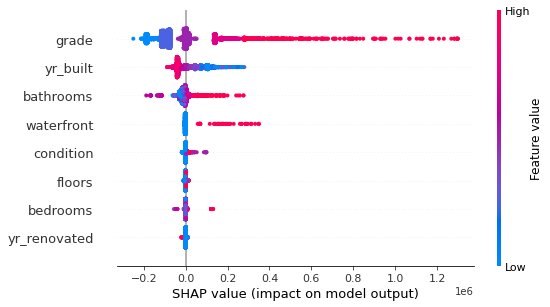

In [13]:
shap.summary_plot(shap_values, test_x)
# grade : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# yr_built : 변수의 값이 낮을 수록, 예상 가격이 높은 경향성이 있다.
# bathrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# bedrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# condition : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다
# waterfront : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
# floors : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)
# yr_renovated : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)

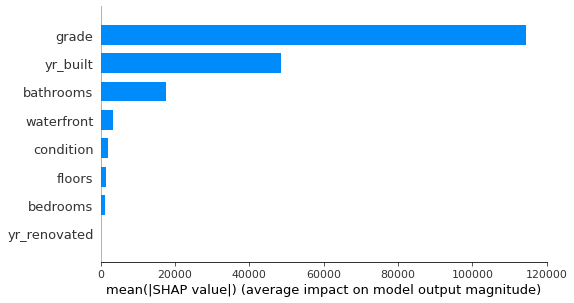

In [14]:
shap.summary_plot(shap_values, test_x, plot_type = "bar") # 각 변수에 대한 Shap Values의 절대값으로 중요도 파악

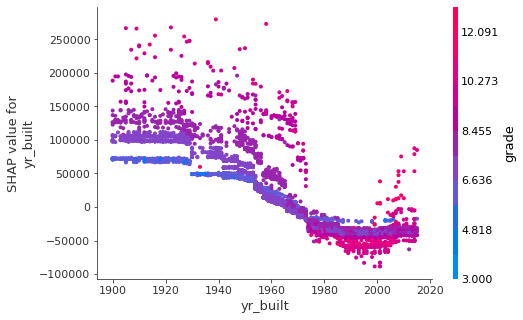

In [15]:
shap.dependence_plot("yr_built", shap_values, test_x)

In [16]:
## https://github.com/slundberg/shap